In [578]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import units as u
from pomegranate import *
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [579]:
def volume_weight(Mpeak, lim_mag=20):
    """Malmquist bias correction for the ZTF CLU volume, assiming a limiting magnitude ~20th mag.
       If distance >200 Mpc we will set distance d=200 Mpc.
       
    Input: 
    ------
    Mpeak (np.array(dtype=float64)): Peak absolute magnitude of the transient
    lim_mag (float64): limiting magnitude of the survey (i.e ZTF limting mag ~20)
    
    Output: 
    -------
    volume weight (np.array(dtype=float64)): 1/vmax weight for a given absolute magnitude. 
    
    """
   
    dist_mod = (lim_mag-Mpeak+5)/5 # distance modulus solved for distance
   
    d = (10**dist_mod * u.pc).to(u.Mpc) # convert distance modulus from parcsec to Mpc 
    
    # If distance is greater than 200 Mpc set distance to 200Mpc again
    maxima = np.where(d.value>200)
    (d.value)[maxima] = 200
   
    volume_sphere = (4/3) * np.pi * (d**3) # volume
    
    return (1/volume_sphere.value) # 1/vmax


def clu_cat_comp(dist, slope=-0.15):
    """ CLU Galaxy Catalog Incompletness Correction. We addopt RCF estimates from 
        the ZTF Bright Transient Survey (Fremling et al. 2020). Returns the weight applied for each distance. 
        
        Input: 
        ------
        dist (float64): distance in Mpc
        slope (float): slope of line
        
        Output: 
        ------ 
        galaxy catalog incompleteness (float): weight
    """
    line = lambda x, e1, e2: x*e1 + e2
    return (line(dist, slope, 80))/100


def generate_random_mixture(loc,sig, Ndata=1000, n_comp=2):
    """Generate a mixture data set for given number of Gaussian components."""
    
    if n_comp==1:
        return np.random.normal(loc, sig, Ndata)
    elif n_comp>1:
        data = np.random.normal(loc, np.random.randint(1, 7), Ndata)
        for i in range(n_comp-1):
            data = np.concatenate([data, np.random.normal(np.random.randint(-25, 25), 
                                                             np.random.randint(1, 2), Ndata)])
        
        return data

## 1.1 - General GMM  and Minimizing BIC/AIC with Pomegranate 
___ 


Text(0.5, 0, '$\\hat y$')

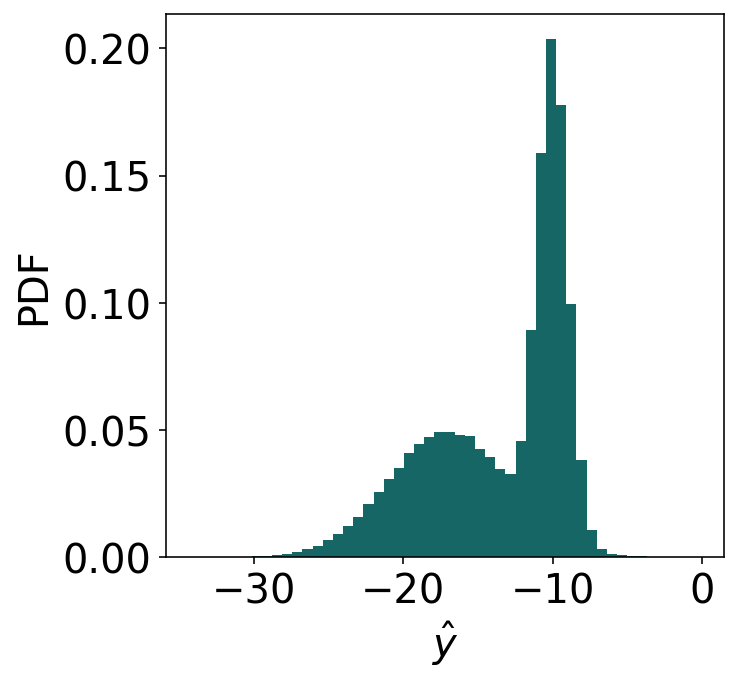

In [879]:
# Assume some arbirary distribution with 3 modes
p = generate_random_mixture(-17, 5,Ndata=100000, n_comp=2)

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
_ = ax.hist(p, color='#166666', bins=50, density=True)
ax.set_ylabel(r"PDF")
ax.set_xlabel(r"$\hat y$")

In [880]:
# Information Criteria 
def aic_calc(lmax, kparams):
    """Calculate the Akaike Information Criterion"""
    return (2*kparams - 2*lmax)

def aic_mod(lmax, kparams, Ndat):
    """Calculated the modified small statistic AIC"""
    AIC = aic_calc(lmax, kparams) 
    return ( AIC + ((2*kparams*(kparams+1))/(Ndat-kparams-1)))

def bic_calc(lmax, kparams, Ndat):
    """Calculate the Bayesian Infromation Criterion"""
    return (kparams * np.log(Ndat) - 2*lmax)

In [1004]:
# Fit normal distribution with K components (K=1,...,5)

K1 = NormalDistribution.from_samples(p)
K1_max = sum(K1.log_probability(p)) # maximumum likelihood can be estimated by Sum(log_probability(X|theta))

K2 = GeneralMixtureModel.from_samples(NormalDistribution, 2, p.reshape(-1, 1))
K2_max = sum(K2.log_probability(p.reshape(-1, 1)))

K3 = GeneralMixtureModel.from_samples(NormalDistribution, 3, p.reshape(-1, 1))
K3_max = sum(K3.log_probability(p.reshape(-1, 1)))

K4 = GeneralMixtureModel.from_samples(NormalDistribution, 4, p.reshape(-1, 1))
K4_max = sum(K4.log_probability(p.reshape(-1, 1)))

K5 = GeneralMixtureModel.from_samples(NormalDistribution, 5, p.reshape(-1, 1))
K5_max = sum(K5.log_probability(p.reshape(-1, 1)))

L_all = np.array([K1_max, K2_max, K3_max, K4_max, K5_max])
comp_all = np.arange(2, 12, step=2) # two parameters per Gaussian component (mean & variance)
N_all = np.zeros(shape=5)
N_all[:] = len(p)

# Estimate BIC for each component K
BIC_vals = bic_calc(L_all, comp_all, N_all)

# Estimate AIC for each component K
AIC_vals = aic_calc(L_all, comp_all)

Text(0, 0.5, 'PDF')

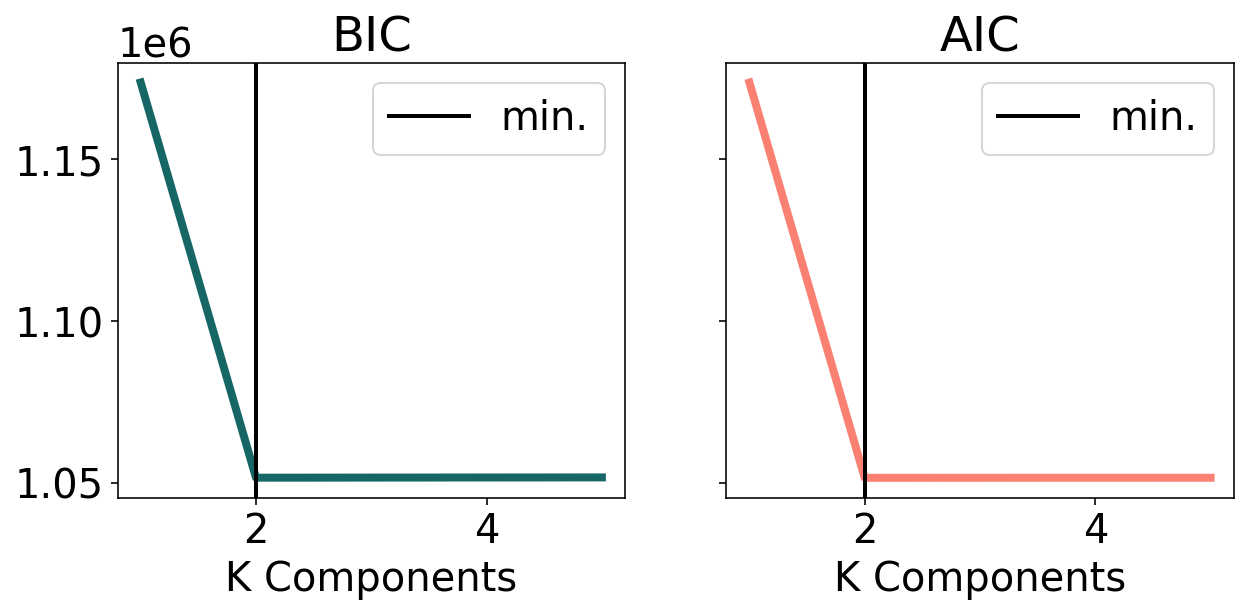

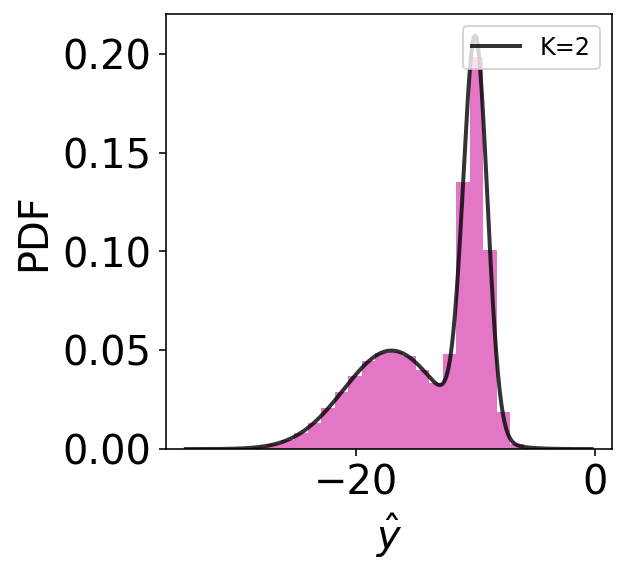

In [1005]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=False, figsize=(10,4))
ax[0].plot(range(1, 6), BIC_vals, lw=4, color='#166666')
ax[0].axvline(range(1,6)[np.argmin(BIC_vals)], color='k', lw=2, label='min.')
ax[0].legend(loc=1)
ax[0].set_xlabel(r"K Components")
ax[0].set_title(r"BIC")

ax[1].plot(range(1, 6), AIC_vals, lw=4, color='salmon')
ax[1].axvline(range(1,6)[np.argmin(BIC_vals)], color='k', lw=2, label='min.')
ax[1].legend(loc=1)
ax[1].set_xlabel(r"K Components")
ax[1].set_title(r"AIC")

plt.figure(figsize=(4,4))
_ = plt.hist(p, bins=30, density=True, histtype='stepfilled', color='#e377c5')
plt.plot(np.linspace(min(p), max(p), 500), K2.probability(np.linspace(min(p), max(p), 500)), color='k', 
        lw=2, alpha=0.8, label='K=2')
plt.legend(loc=1, fontsize=12)
plt.ylim(0, 0.22)
plt.xlabel(r"$\hat y$")
plt.ylabel(r"PDF")

## 1.2 - Weighted GMM  and Minimizing AIC with Pomegranate 
___ 

In [990]:
# Generate a single gaussian with one component 
p0 = generate_random_mixture(-20.1, 2.01, Ndata=50000, n_comp=1)

Text(0.5, 0, '$\\hat y$')

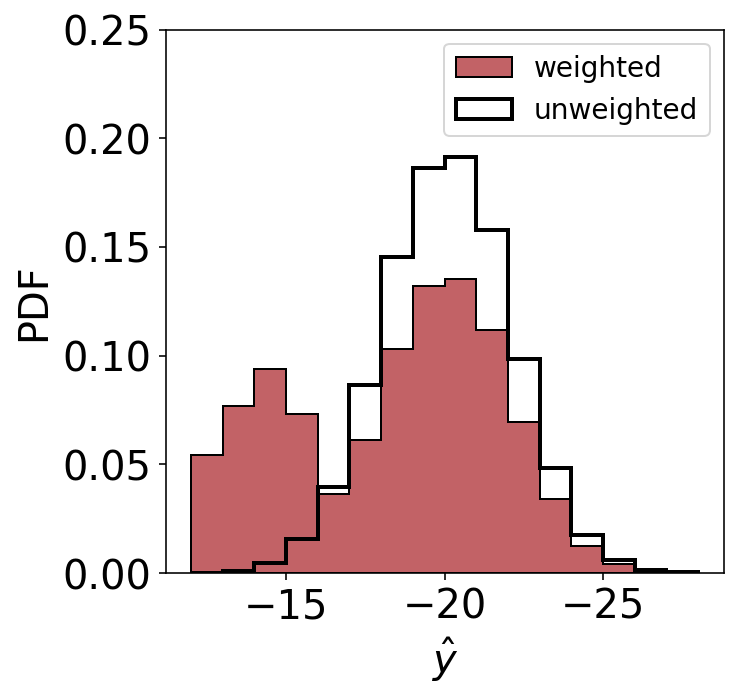

In [992]:
# Assume normal distribution for distance (Mpc)
d0 = np.random.normal(130, 50, len(p0))

# Weights: 1/vmax * clu_cat_comp
W  = volume_weight(p0)*clu_cat_comp(d0)
W = (W-min(W))/(max(W)-min(W)) # scale weights 1-0

plt.figure(figsize=(5,5))
_ = plt.hist(p0, weights=W,
             bins=np.arange(-28, -11, step=1), 
            density=True, histtype='stepfilled', lw=1, color='#c26266', edgecolor='k', 
            label='weighted')

_ = plt.hist(p0, density=True, bins=np.arange(-28, -11, step=1), 
            histtype='step', lw=2, color='k', label='unweighted')

plt.legend(loc=1, fontsize=14)
plt.ylim(0, 0.25)
plt.xlim(plt.xlim()[::-1])
plt.ylabel(r"PDF")
plt.xlabel(r"$\hat y$")

BIC: 
K=1 component: 211628.76302562398
K=2 components: 211660.29451088145
K=3 components: 211684.35710252612
AIC: 
K=1 component: 311607.12346905516
K=2 components: 311617.0153977438
K=3 components: 311619.4384328197


Text(0.5, 0, '$\\hat y$')

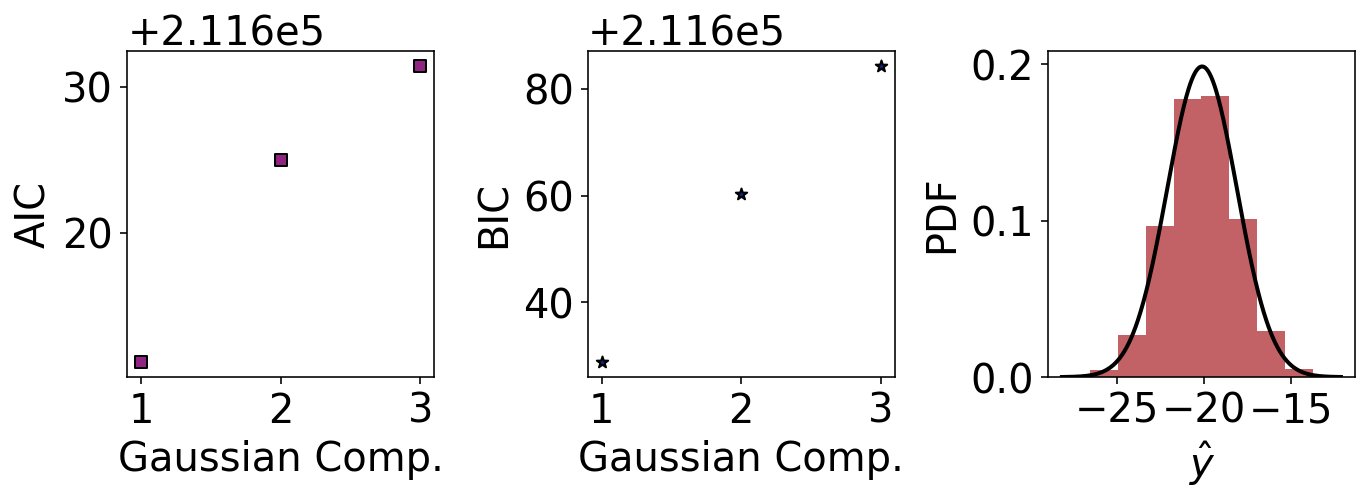

In [1021]:
# minimize AIC on unweighted data for K=1,2,3 components
K1 = NormalDistribution.from_samples(p0.reshape(-1,1))
K1_max = sum(K1.log_probability(p0)) # maximum likelihood 

K2 = GeneralMixtureModel.from_samples([NormalDistribution], 2, p0.reshape(-1, 1))
K2_max = sum(K2.log_probability(p0)) # maximum likelihood 
                                     
K3 = GeneralMixtureModel.from_samples([NormalDistribution],
                                      3, p0.reshape(-1, 1))
K3_max = sum(K3.log_probability(p0)) # maximum likelihood 

print (r"BIC: ")
print (f"K=1 component: {bic_calc(sum(K1.log_probability(p0)), 2, len(p0))}")
print (f"K=2 components: {bic_calc(sum(K2.log_probability(p0)), 4, len(p0))}")
print (f"K=3 components: {bic_calc(sum(K3.log_probability(p0)), 6, len(p0))}")


print (r"AIC: ")
print (f"K=1 component: {aic_calc(sum(K1.log_probability(p0)), len(p0))}")
print (f"K=2 components: {aic_calc(sum(K2.log_probability(p0)), len(p0))}")
print (f"K=3 components: {aic_calc(sum(K3.log_probability(p0)), len(p0))}")

# Plot AIC and lowest AIC Gaussian component
AIC_vals = [aic_calc(sum(K1.log_probability(p0)), 2), 
            aic_calc(sum(K2.log_probability(p0)), 4),
            aic_calc(sum(K3.log_probability(p0)), 6)]

BIC_vals = [bic_calc(sum(K1.log_probability(p0)), 2, len(p0)), 
            bic_calc(sum(K2.log_probability(p0)), 4, len(p0)),
            bic_calc(sum(K3.log_probability(p0)), 6, len(p0))]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11,3))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

for i in range(3):
    ax[0].scatter(i+1, AIC_vals[i], color='#912382', edgecolor='k', marker='s')
    ax[1].scatter(i+1, BIC_vals[i], color='#112382', edgecolor='k', marker='*')

ax[0].set_ylabel(r"AIC")
ax[0].set_xlabel(r"Gaussian Comp.")
ax[1].set_xlabel(r"Gaussian Comp.")
ax[1].set_ylabel(r"BIC")

ax[2].plot(np.linspace(min(p0), max(p0), 500), K1.probability(np.linspace(min(p0), max(p0), 500)), color='k', lw=2)
_ = ax[2].hist(p0, bins=10, histtype='stepfilled', density=True, color='#c26266')
ax[2].set_ylabel(r"PDF")
ax[2].set_xlabel(r"$\hat y$")

$$\begin{equation} \mathcal{L^w_{max}} = \sum_{j=1}^{N} w_{j} log P(x_{i} | \theta) \end{equation}$$
$$\begin{equation} J=1 \end{equation}$$

Next, the minimization of the BIC/AIC on a weighted GMM. For each observation ($\hat y$) we have an associated weight ($w$) that is normalized from 0-1. 

`pomegranete` implements it's weighed maxmimum likelihood function desribed as: 

#### $$\begin{equation} \mathcal{L^w} = L^{w} (x|\theta) = \prod_{i=1}^{N} P(x_{i} | \theta)^{w_i} \end{equation}$$ 

by maximizing the likelihood function we get: 

#### $$\begin{equation} \mathcal{L^w_{max}} = \sum_{i=1}^{N} w_{i} log P(x_{i} | \theta) \end{equation}$$

Hence we can slightly modify the BIC and AIC equations to reflect that of the weighted maximized likelihood function: 

#### $$\begin{equation} BIC^w =  klog(N) - 2\sum_{i=1}^{N} w_{i} log P(x_{i} | \theta) \end{equation}$$

#### $$\begin{equation} AIC^w = 2k - 2\sum_{i=1}^{N} w_{i} log P(x_{i} | \theta) \end{equation}$$

In [994]:
# Maximizing the likelihood function can be done in pomegranete by two methods: 
model = GeneralMixtureModel.from_samples([NormalDistribution],
                                         2,
                                         p0.reshape(-1, 1),
                                         weights=W.T) # K=2 model 

print (f"Maximized log-likelihood function (via summarize): {model.summarize(p0, weights=W)}") # using the summarize function
print (f"Maximized log-likelihood function by hand: {sum(W*model.log_probability(p0))}") # sum W * log_p

Maximized log-likelihood function (via summarize): -214.1970754438533
Maximized log-likelihood function by hand: -214.1970754438533


Now we will perform a BIC/AIC analysis on the weighted `p0` data:

BIC: 
K=1 component: 470.7792625615198
K=2 component: 471.76983879967236
K=3 component: 493.65715173444863
AIC: 
K=1 component: 453.1397059926992
K=2 component: 436.49072566203125
K=3 component: 440.73848202798695


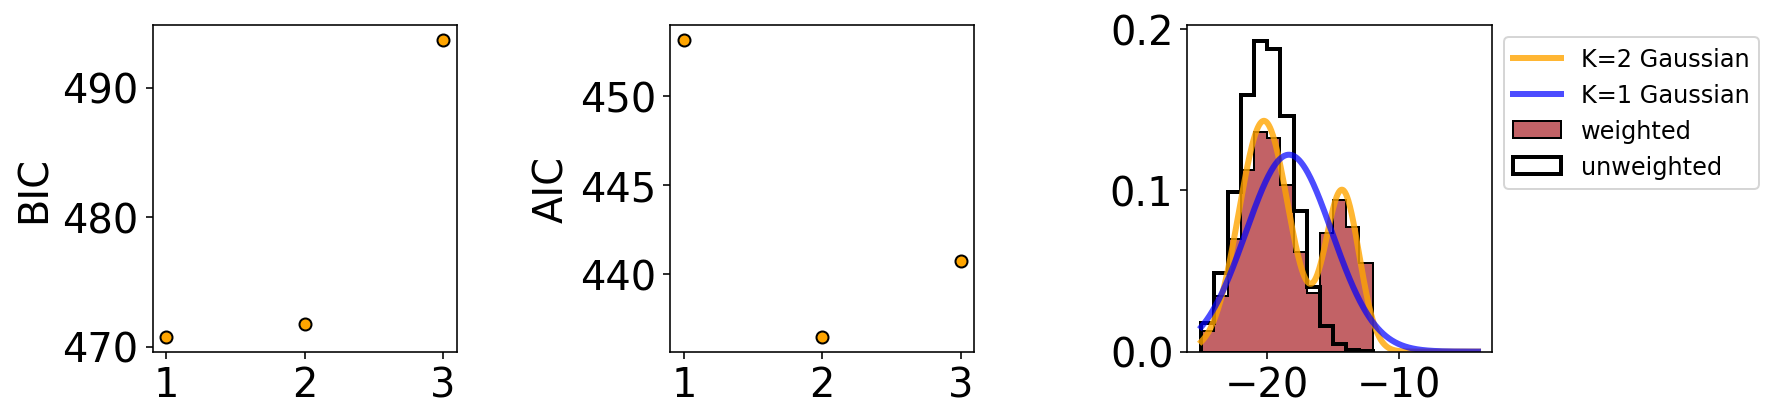

In [1020]:
K1 = NormalDistribution.from_samples(p0.reshape(-1,1), weights=W.T)
K1_max = sum(W * K1.log_probability(p0)) # maximum likelihood for weighted data 

K2 = GeneralMixtureModel.from_samples([NormalDistribution], 2, p0.reshape(-1, 1), weights=W.T)
K2_max = sum(W * K2.log_probability(p0)) # maximum likelihood for weighted data                                       

K3 = GeneralMixtureModel.from_samples([NormalDistribution],
                                      3, p0.reshape(-1, 1),
                                          weights=W.T)
K3_max = sum(W * K3.log_probability(p0)) # maximum likelihood for weighted data 
                                      
      
print (r"BIC: ") 
print (f"K=1 component: {bic_calc(K1_max, 2, len(p0))}") # max
print (f"K=2 component: {bic_calc(K2_max, 4, len(p0))}") # max
print (f"K=3 component: {bic_calc(K3_max, 6, len(p0))}") # max
        

print (r"AIC: ") 
print (f"K=1 component: {aic_calc(K1_max, 2)}") # max
print (f"K=2 component: {aic_calc(K2_max, 4)}") # max
print (f"K=3 component: {aic_calc(K3_max, 6)}") # max


# Plot AIC and lowest AIC Gaussian component
AIC_vals = [aic_calc(K1_max, 2), aic_calc(K2_max, 4), aic_calc(K3_max, 6)]

BIC_vals = [bic_calc(K1_max, 2, len(p0)), bic_calc(K2_max, 4, len(p0)), bic_calc(K3_max, 6, len(p0))]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)

for i in range(3):
    ax[1].scatter(i+1, AIC_vals[i], color='orange', edgecolor='k')
    ax[0].scatter(i+1, BIC_vals[i], color='orange', edgecolor='k')

ax[0].set_ylabel(r"BIC")
ax[1].set_ylabel(r"AIC")

ax[2].plot(np.linspace(-25, -4, 500), K2.probability(np.linspace(-25, -4, 500)), color='orange', lw=3,
        label='K=2 Gaussian', alpha=0.8)
ax[2].plot(np.linspace(-25, -4, 500), K1.probability(np.linspace(-25, -4, 500)), color='blue', lw=3,
        label='K=1 Gaussian', alpha=0.7)

_ = ax[2].hist(p0, weights=W,
             bins=np.arange(-25, -11, step=1), 
            density=True, histtype='stepfilled', lw=1, color='#c26266', edgecolor='k', 
            label='weighted')

_ = ax[2].hist(p0, density=True, bins=np.arange(-25, -11, step=1), 
            histtype='step', lw=2, color='k', label='unweighted')
ax[2].legend(fontsize=12, bbox_to_anchor=(1,1))

